In [834]:
!pip install p3_data

In [835]:
%matplotlib inline
import pandas as pd
import numpy as np
import matplotlib
import matplotlib.pylab as plt
import matplotlib.dates as mdates
import matplotlib.cm as cm
import seaborn as sns
import json
from io import StringIO
import importlib

In [836]:
import p3_data
from p3_data import (glob_file_list, load_json_from_file, merge_dicts, plot_groups, 
    get_varying_column_names, filter_dataframe, take_varying_columns,
    load_json_records_as_dataframe)

In [1799]:
# Load result files from P3 Test Driver
src_files = []

# Pulsar 2.6.0 ecs s3 tier2 07.07.2020

## attempt1 brokers out of direct memory
#src_files += ['../../../../../tests/Pulsar-ecs-s3-tier2-Redhook/Pulsar-2.6.0-tier2-ecs-s3-07.07.2020-10k-16p-18tests-attempt1-broker-outofdirectmem/data/p3_test_driver/results/*.json']

## attempt2 bookies out of direct memory
#src_files += ['../../../../../tests/Pulsar-ecs-s3-tier2-Redhook/pulsar-2.6.0-tier2-ecs-s3-07.07.2020-10k-16p-19tests-attempt2-bk-outofdirectmem/data/p3_test_driver/results/*.json']

## attempt3 broker out of direct memory
#src_files += ['../../../../../tests/Pulsar-ecs-s3-tier2-Redhook/pulsar-2.6.0-tier2-ecs-s3-07.07.2020-10k-16p-19tests-attempt3-broker-directmemOOM/data/p3_test_driver/results/*.json']
#src_files += ['../../../../../tests/Pulsar-ecs-s3-tier2-Redhook/pulsar-2.6.0-tier2-ecs-s3-07.07.2020-10k-16p-19tests-attempt3-broker-directmemOOM/data/p3_test_driver/results_cleared/*.json']

# Pulsar 2.6.0 ecs s3 tier2 07.07.2020
## attempt4 broker out of direct memory - 52 tests
#src_files += ['../../../../../tests/Pulsar-ecs-s3-tier2-Redhook/pulsar-2.6.0-tier2-ecs-s3-07.07.2020-10k-16p-52tests-attempt4/data/p3_test_driver/results_cleared/*.json']

# pulsar-2.6.0-no-tiered-10.07.2020-46tests-success
src_files += ['../../../../../tests/Pulsar-ecs-s3-tier2-Redhook/pulsar-2.6.0-no-tiered-10.07.2020-46tests-success/data/p3_test_driver/results_cleared/*.json']
#---------------------------------------------------------

### Pulsar 2.5.2 15.06.2020 44 tests different amount of workers
# src_files += ['../../../../../tests/pulsar_2.5.2_44_tests_15.06/data/p3_test_driver/results/*.json']

### Pulsar 2.5.2 17.06.2020 44 tests different amount of workers
#src_files += ['../../../../../tests/Pulsar-2.5.2-17.06.20-44tests/data/p3_test_driver/results_cleared/*.json']

#-------------------------------------------------------------------------
# Pulsar fresh tests 2.5.2 
src_files += ['../../../../../tests/Pulsar-ecs-s3-tier2-Redhook/Pulsar-2.5.2-no_tier2_11.07.2020/pulsar-2.5.2-10k_1p_16p_100b_1p_no_tier2_47tests-11.07.2020/data/p3_test_driver/results/*.json']

# Pravega 0.8.0-2577.15b0f5eb9 tier2 29.06.2020
#src_files += ['../../../../tests/pravega-15b0f5eb9-tier2-29.06.2020-10k-100b/pravega-0.8.0-2577.15b0f5eb9-tier2-10k-28tests-29.06.2020/data/p3_test_driver/results/*.json']

# pravega-0.8.0-2656.1c40f1e-no_netty_Isilon-nfs-tier2 09.07.2020 48 tests success
#src_files += ['../../../../../tests/Pravega-1c40f1e-NO_NETTY-nfs-Isilon-tier2-48tests-succsess-09.07.2020/data/p3_test_driver/results/*.json']

### PRAVEGA 15b0f5eb9 (master) Isilon nfs omb 2b28b32 (no_netty) 09.07.2020 48tests success
src_files += ['../../../../../tests/PRAVEGA-15b0f5eb9-Isilon-nfs-omb-2b28b32-09.07.2020-48tests/data/p3_test_driver/results/*.json']

raw_df = load_json_records_as_dataframe(src=src_files, ignore_error=True)

Loading records from 137 files...


In [1800]:
# Clean raw results
def clean_result(result):
    try:
        r = result.copy()
        r['utc_begin'] = pd.to_datetime(r['utc_begin'], utc=True)
        r['utc_end'] = pd.to_datetime(r['utc_end'], utc=True)
        r['git_commit'] = r['git_commit'].split(' ')[0]
        r['driverName'] = r['driver']['name']
        if r['driverName'] == 'Pulsar':
            r = merge_dicts(r, r['driver']['client']['persistence'])
        r = merge_dicts(r, r['workload'])
        del r['workload']
        r = merge_dicts(r, r['omb_results'])
        if 'ansible_vars' in r and isinstance(r['ansible_vars'], dict):
            r = merge_dicts(r, r['ansible_vars'])
        if r['driverName'] == 'Pravega':
            if 'pravegaVersion' not in r:
                r['pravegaVersion'] = '1c40f1e-no_netty_Isilon-nfs-tier2'
            r['pravegaVersion'] = r['pravegaVersion'].replace('-SNAPSHOT','')
        for k in list(r.keys()):
            if 'Quantiles' in k:
                r[k] = pd.Series(data=[float(q) for q in r[k].keys()], index=list(r[k].values())).sort_index() / 100
            elif isinstance(r[k], list) and 'Rate' in k:
                r[k] = pd.Series(r[k])
                r['%sMean' % k] = r[k].mean()
        r['numWorkloadWorkers'] = int(r.get('numWorkers', 0))
        r['throttleEventsPerSec'] = r['producerRate']
        r['publishRateEventsPerSecMean'] = r['publishRateMean']
        r['consumeRateEventsPerSecMean'] = r['consumeRateMean']
        r['publishRateMBPerSecMean'] = r['publishRateMean'] * r['messageSize'] * 1e-6
        r['consumeRateMBPerSecMean'] = r['consumeRateMean'] * r['messageSize'] * 1e-6
        r['publishLatencyMsAvg'] = r['aggregatedPublishLatencyAvg']
        r['publishLatencyMs50Pct'] = r['aggregatedPublishLatency50pct']
        r['publishLatencyMs99Pct'] = r['aggregatedPublishLatency99pct']
        r['endToEndLatencyMsAvg'] = r['aggregatedEndToEndLatencyAvg']
        r['endToEndLatencyMs50Pct'] = r['aggregatedEndToEndLatency50pct']
        r['endToEndLatencyMs99Pct'] = r['aggregatedEndToEndLatency99pct']
        
        if r['driverName'] == 'Pulsar':
            r['version'] = r['pulsarVersion']
            
        if r['driverName'] == 'Pravega':    
            r['version'] = r['pravegaVersion']   
        
        return pd.Series(r)
    except Exception as e:
        print('ERROR: %s: %s' % (r['test_uuid'], e))
        # raise e

In [1801]:
# r = clean_result(raw_df.iloc[-1])
# pd.DataFrame(r)

In [1802]:
clean_df = raw_df.apply(clean_result, axis=1)
clean_df = clean_df.set_index('test_uuid', drop=False)
clean_df = clean_df[clean_df.error==False]
clean_df = clean_df.sort_values(['utc_begin'])

In [1803]:
# Show list of columns
clean_df.columns.values

array(['ackQuorum', 'aggregatedEndToEndLatency50pct',
       'aggregatedEndToEndLatency75pct', 'aggregatedEndToEndLatency95pct',
       'aggregatedEndToEndLatency9999pct',
       'aggregatedEndToEndLatency999pct',
       'aggregatedEndToEndLatency99pct', 'aggregatedEndToEndLatencyAvg',
       'aggregatedEndToEndLatencyMax',
       'aggregatedEndToEndLatencyQuantiles',
       'aggregatedPublishLatency50pct', 'aggregatedPublishLatency75pct',
       'aggregatedPublishLatency95pct', 'aggregatedPublishLatency9999pct',
       'aggregatedPublishLatency999pct', 'aggregatedPublishLatency99pct',
       'aggregatedPublishLatencyAvg', 'aggregatedPublishLatencyMax',
       'aggregatedPublishLatencyQuantiles', 'ansible', 'ansible_vars',
       'aws-ec2', 'backlog', 'bookkeeperVersion', 'build',
       'command_timed_out', 'consumeRate', 'consumeRateEventsPerSecMean',
       'consumeRateMBPerSecMean', 'consumeRateMean',
       'consumerBacklogSizeGB', 'consumerPerSubscription',
       'deduplicationE

In [1804]:
# Define columns that identify test parameters
param_cols = [
    'numWorkloadWorkers',
    'topics',
    'partitionsPerTopic',
    'producersPerTopic',
    'subscriptionsPerTopic',
    'consumerPerSubscription',
    'testDurationMinutes',
    'keyDistributor',
    'git_commit',
    'driverName',
    'version'
]

In [1805]:
# Define columns that are the output of the experiments
output_cols = [
    'publishRateEventsPerSecMean',
    'consumeRateEventsPerSecMean',
    'consumeRateMBPerSecMean',
    'publishRateMBPerSecMean',
    'publishLatencyMs50Pct',
    'publishLatencyMs99Pct',
    'endToEndLatencyMs50Pct',
    'endToEndLatencyMs99Pct',
    'throttleEventsPerSec',
    'utc_begin',    
]

In [1806]:
cols = param_cols + output_cols

In [1807]:
# View most recent results
clean_df[cols].tail(38).T

test_uuid,2a6c5e6f-d5d0-4b4d-aec9-6d5f3ae62094,77f15070-6d4e-4c3c-a8ef-169ca5177095,f581f846-7aa5-4cc0-8dd9-a534122a8157,7ca89608-2a78-4a62-933f-3aa5650e0cfa,57f72efd-7f69-4f74-868d-f397307b5422,ca6c67ac-af4f-4cf7-aa22-223f7cf775af,df8f8deb-1867-470b-9dd2-4217c8bd066a,6ae69153-73f9-49c8-b90b-bca6143c53ea,d31878db-30ba-47e0-bb58-77990b8bc44b,03a1e4b7-e9d4-4ee8-8e78-069addb961f6,...,9555fdac-0679-4a38-9595-c0703ad0d80d,01cdece0-14d0-47b3-82c7-d3e091957dc3,03a603a4-77e0-44ef-8699-2c932fa8f460,7ff7947d-62d0-4bf7-9820-c27a590c4ad3,c9438a0e-5825-4db4-8e57-b4a79be37f44,9a50e881-d04d-4fe6-82fe-2f93b8c6ea27,317e8e3c-1ee7-4e03-9789-cc54592dbed6,d9372349-096e-4094-8258-179b122d812c,3e6b75e7-698f-47a4-ba88-cbd7aec8b673,6f852021-9fb3-44ee-80f8-1a6e92e36731
numWorkloadWorkers,4,4,4,4,4,4,4,4,4,4,...,4,4,4,4,4,4,4,4,4,4
topics,4,4,4,4,4,4,4,4,4,4,...,4,4,4,4,4,4,4,4,4,4
partitionsPerTopic,1,1,1,1,1,16,16,16,16,16,...,16,16,16,16,16,16,16,16,16,16
producersPerTopic,4,4,4,4,4,4,4,4,4,4,...,4,4,4,4,4,4,4,4,4,4
subscriptionsPerTopic,1,1,1,1,1,1,1,1,1,1,...,1,1,1,1,1,1,1,1,1,1
consumerPerSubscription,4,4,4,4,4,4,4,4,4,4,...,4,4,4,4,4,4,4,4,4,4
testDurationMinutes,2,2,2,2,2,2,2,2,2,2,...,2,2,2,2,2,2,2,2,2,2
keyDistributor,NO_KEY,NO_KEY,NO_KEY,NO_KEY,NO_KEY,NO_KEY,NO_KEY,NO_KEY,NO_KEY,NO_KEY,...,NO_KEY,NO_KEY,NO_KEY,NO_KEY,NO_KEY,NO_KEY,NO_KEY,NO_KEY,NO_KEY,NO_KEY
git_commit,326cb35,326cb35,326cb35,326cb35,326cb35,1793eb2,1793eb2,1793eb2,1793eb2,1793eb2,...,b9205ee,b9205ee,b9205ee,b9205ee,b9205ee,b9205ee,b9205ee,b9205ee,b9205ee,b9205ee
driverName,Pulsar,Pulsar,Pulsar,Pulsar,Pulsar,Pulsar,Pulsar,Pulsar,Pulsar,Pulsar,...,Pulsar,Pulsar,Pulsar,Pulsar,Pulsar,Pulsar,Pulsar,Pulsar,Pulsar,Pulsar


In [1808]:
# Export to CSV
#clean_df[cols].to_csv('openmessaging-benchmark-results.csv')

In [1809]:
# df = clean_df[cols]
# df = df.sort_values(['messageSize','numWorkloadWorkers','producersPerTopic','throttleEventsPerSec','utc_begin'])
# df.head()

In [1810]:
# View distinct values of pravegaVersion and test counts
clean_df.groupby(['version']).size()

version
0.8.0-2656.15b0f5eb9-no_netty-client-Isilon-tier2    48
2.5.2                                                46
2.6.0-not-tiered                                     43
dtype: int64

In [1811]:
# First level of filtering
filt_df = filter_dataframe(
    clean_df,
    #version='2.6.0-not-tiered',
    #driverName='Pulsar',
    #pulsarVersion='2.5.2',
    #pravegaVersion='0.8.0-2656.15b0f5eb9-no_netty-client-Isilon-tier2',
    numWorkloadWorkers=4, 
    topics=4,
    testDurationMinutes=2,
   # size_of_test_batch=(2,1000), # between
   # aggregatedEndToEndLatency50pct=(1,1e6),
)
# filt_df = filt_df[filt_df.size_of_test_batch > 1]
len(filt_df)

137

In [1812]:
def latency_vs_publish_throughput_table(df):
    result_df = (df
        .set_index(['publishRateMBPerSecMean'])
        .sort_index()
        [[
            'aggregatedPublishLatency50pct',
            'aggregatedPublishLatency95pct',
            'aggregatedPublishLatency99pct',
            'aggregatedEndToEndLatency50pct',
            'aggregatedEndToEndLatency95pct',
            'aggregatedEndToEndLatency99pct',
            'test_uuid',
        ]]
        .rename(columns=dict(
            aggregatedPublishLatency50pct='Publish Latency p50',
            aggregatedPublishLatency95pct='Publish Latency p95',
            aggregatedPublishLatency99pct='Publish Latency p99',
            aggregatedEndToEndLatency50pct='E2E Latency p50',
            aggregatedEndToEndLatency95pct='E2E Latency p95',
            aggregatedEndToEndLatency99pct='E2E Latency p99',
        ))
        )
    result_df.index.name = 'Achieved Publish Throughput (MB/s)'
    return result_df

In [1813]:
def latency_vs_consume_throughput_table(df):
    result_df = (df
        .set_index(['consumeRateMBPerSecMean'])
        .sort_index()
        [[
            'aggregatedPublishLatency50pct',
            'aggregatedPublishLatency95pct',
            'aggregatedPublishLatency99pct',
            'aggregatedEndToEndLatency50pct',
            'aggregatedEndToEndLatency95pct',
            'aggregatedEndToEndLatency99pct',
            'test_uuid',
        ]]
        .rename(columns=dict(
            aggregatedPublishLatency50pct='Publish Latency p50',
            aggregatedPublishLatency95pct='Publish Latency p95',
            aggregatedPublishLatency99pct='Publish Latency p99',
            aggregatedEndToEndLatency50pct='E2E Latency p50',
            aggregatedEndToEndLatency95pct='E2E Latency p95',
            aggregatedEndToEndLatency99pct='E2E Latency p99',
        ))
        )
    result_df.index.name = 'Achieved Consume Throughput (MB/s)'
    return result_df

In [1814]:
def latency_vs_provided_rate_table(df):
    result_df = (df
        .set_index(['throttleEventsPerSec'])
        .sort_index()
        [[
            'aggregatedPublishLatency50pct',
            'aggregatedPublishLatency95pct',
            'aggregatedPublishLatency99pct',
            'aggregatedEndToEndLatency50pct',
            'aggregatedEndToEndLatency95pct',
            'aggregatedEndToEndLatency99pct',
            'test_uuid',
        ]]
        .rename(columns=dict(
            aggregatedPublishLatency50pct='Publish Latency p50',
            aggregatedPublishLatency95pct='Publish Latency p95',
            aggregatedPublishLatency99pct='Publish Latency p99',
            aggregatedEndToEndLatency50pct='E2E Latency p50',
            aggregatedEndToEndLatency95pct='E2E Latency p95',
            aggregatedEndToEndLatency99pct='E2E Latency p99',
        ))
        )
    result_df.index.name = 'Throttle Events Per Second'
    return result_df

In [1815]:
def plot_latency_vs_consume_throughput(df):
    assert len(df.messageSize.drop_duplicates().values) == 1
    messageSize = df.messageSize.iloc[0]
    partitionsPerTopic = df.partitionsPerTopic.iloc[0]
    testDurationMinutes = df.testDurationMinutes.iloc[0]
    topics = df.topics.iloc[0]
    producersPerTopic = df.producersPerTopic.iloc[0]
    consumerPerSubscription = df.consumerPerSubscription.iloc[0]
    version = df.version.iloc[0]
    driver = df.driver.iloc[0]
    plot_df = latency_vs_consume_throughput_table(df)
    title = '%s %s , message Size %d, partitions: %d producersPerTopic: %d consumerPerSubscription: %d topics: %d  %dmin test' % (driver, version, messageSize, partitionsPerTopic, producersPerTopic, consumerPerSubscription, topics, testDurationMinutes)
    ax = plot_df.plot(
        logx=True, 
        logy=True,
        figsize=(10,8),
        grid=True, 
        title=title, 
        style=['x:b','x-.b','x-b','+:r','+-.r','+-r'])
    ax.set_ylabel('Latency (ms)');
    tick_formatter = matplotlib.ticker.LogFormatter()
    ax.xaxis.set_major_formatter(tick_formatter)
    ax.yaxis.set_major_formatter(tick_formatter)
    ax.grid('on', which='both', axis='both')

In [1816]:
def plot_latency_vs_publish_throughput(df):
    assert len(df.messageSize.drop_duplicates().values) == 1
    messageSize = df.messageSize.iloc[0]
    partitionsPerTopic = df.partitionsPerTopic.iloc[0]
    testDurationMinutes = df.testDurationMinutes.iloc[0]
    topics = df.topics.iloc[0]
    producersPerTopic = df.producersPerTopic.iloc[0]
    consumerPerSubscription = df.consumerPerSubscription.iloc[0]
    version = df.version.iloc[0]
    driver = df.driver.iloc[0]
    plot_df = latency_vs_publish_throughput_table(df)
    title = '%s %s , message Size %d, partitions: %d producersPerTopic: %d consumerPerSubscription: %d topics: %d  %dmin test' % (driver, version, messageSize, partitionsPerTopic, producersPerTopic, consumerPerSubscription, topics, testDurationMinutes)
    ax = plot_df.plot(
        logx=True, 
        logy=True,
        figsize=(10,8),
        grid=True, 
        title=title, 
        style=['x:b','x-.b','x-b','+:r','+-.r','+-r'])
    ax.set_ylabel('Latency (ms)');
    tick_formatter = matplotlib.ticker.LogFormatter()
    ax.xaxis.set_major_formatter(tick_formatter)
    ax.yaxis.set_major_formatter(tick_formatter)
    ax.grid('on', which='both', axis='both')

In [1817]:
def plot_latency_vs_provided_rate(df):
    assert len(df.messageSize.drop_duplicates().values) == 1
    messageSize = df.messageSize.iloc[0]
    partitionsPerTopic = df.partitionsPerTopic.iloc[0]
    testDurationMinutes = df.testDurationMinutes.iloc[0]
    topics = df.topics.iloc[0]
    producersPerTopic = df.producersPerTopic.iloc[0]
    consumerPerSubscription = df.consumerPerSubscription.iloc[0]
    version = df.version.iloc[0]
    driver = df.driver.iloc[0]
    plot_df = latency_vs_provided_rate_table(df)
    title = '%s %s, message Size %d, partitions: %d producersPerTopic: %d consumerPerSubscription: %d topics: %d  %dmin test' % (driver, version, messageSize, partitionsPerTopic, producersPerTopic, consumerPerSubscription, topics, testDurationMinutes)
    ax = plot_df.plot(
        logx=True, 
        logy=True,
        figsize=(10,8),
        grid=True, 
        title=title, 
        style=['x:b','x-.b','x-b','+:r','+-.r','+-r'])
    ax.set_ylabel('Latency (ms)');
    tick_formatter = matplotlib.ticker.LogFormatter()
    ax.xaxis.set_major_formatter(tick_formatter)
    ax.yaxis.set_major_formatter(tick_formatter)
    ax.grid('on', which='both', axis='both')

In [1818]:
def plot_latency_vs_provided_rate_normal(df):
    assert len(df.messageSize.drop_duplicates().values) == 1
    messageSize = df.messageSize.iloc[0]
    partitionsPerTopic = df.partitionsPerTopic.iloc[0]
    testDurationMinutes = df.testDurationMinutes.iloc[0]
    topics = df.topics.iloc[0]
    producersPerTopic = df.producersPerTopic.iloc[0]
    consumerPerSubscription = df.consumerPerSubscription.iloc[0]
    version = df.version.iloc[0]
    driver = df.driver.iloc[0]
    plot_df = latency_vs_provided_rate_table(df)
    title = '%s %s , message Size %d, partitions: %d producersPerTopic: %d consumerPerSubscription: %d topics: %d  %dmin test' % (driver, version, messageSize, partitionsPerTopic, producersPerTopic, consumerPerSubscription, topics, testDurationMinutes)
    ax = plot_df.plot(
        logx=False, 
        logy=False,
        figsize=(10,8),
        grid=True, 
        title=title, 
        style=['x:b','x-.b','x-b','+:r','+-.r','+-r'])
    ax.set_ylabel('Latency (ms)');
    tick_formatter = matplotlib.ticker.LogFormatter()
    ax.xaxis.set_major_formatter(tick_formatter)
    ax.yaxis.set_major_formatter(tick_formatter)
    ax.grid('on', which='both', axis='both')

## Message Size 100 B

In [1944]:
filt_100_df = filter_dataframe(
    filt_df,
    messageSize=100,
    producersPerTopic=4,
    partitionsPerTopic=16,
    version='0.8.0-2656.15b0f5eb9-no_netty-client-Isilon-tier2',
    #version='2.6.0-not-tiered',
    #version='2.5.2',
    topics=4
)

In [1945]:
# View varying columns
take_varying_columns(filt_100_df[filt_100_df.producerRate==100000]).T

test_uuid


In [1946]:
# View distinct sets of parameters.
# There should only be one distinct set of parameters.
filt_100_df[param_cols].drop_duplicates().T

test_uuid,68ffebf8-bae2-4189-b5ff-9404ef99d874
numWorkloadWorkers,4
topics,4
partitionsPerTopic,16
producersPerTopic,4
subscriptionsPerTopic,1
consumerPerSubscription,4
testDurationMinutes,2
keyDistributor,NO_KEY
git_commit,88dbf86
driverName,Pravega


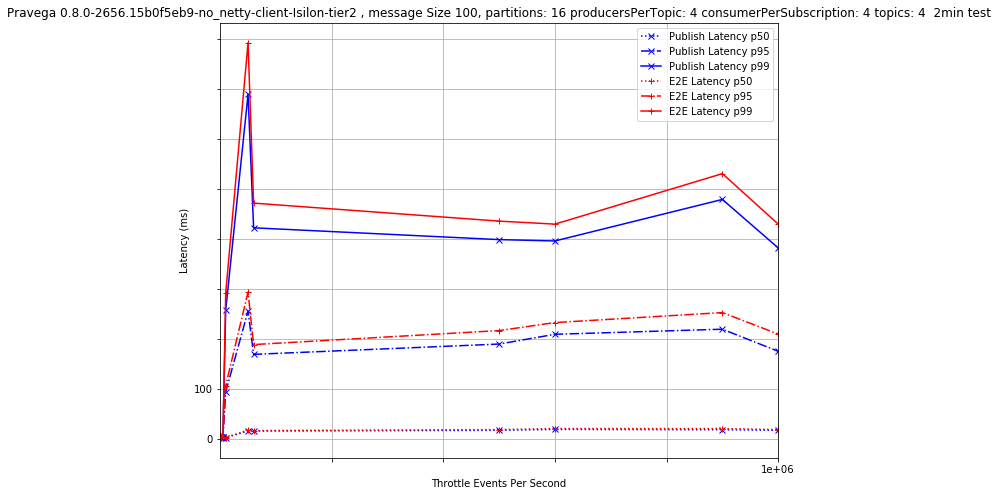

In [1947]:
plot_latency_vs_provided_rate_normal(filt_100_df)

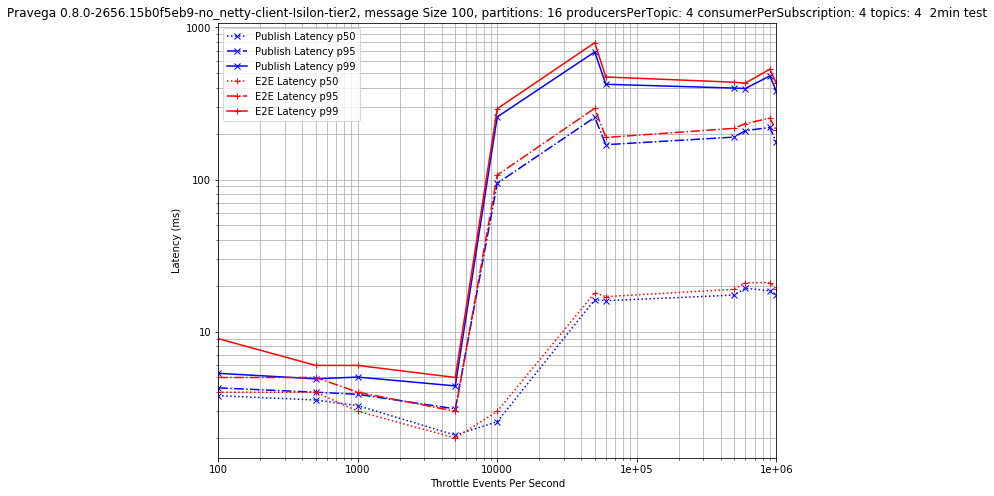

In [1948]:
plot_latency_vs_provided_rate(filt_100_df)

In [1949]:
latency_vs_provided_rate_table(filt_100_df)

,Publish Latency p50,Publish Latency p95,Publish Latency p99,E2E Latency p50,E2E Latency p95,E2E Latency p99,test_uuid
Throttle Events Per Second,,,,,,,
100.0,3.797,4.272,5.325,4.0,5.000,9.000,c202bfac-00dc-4caa-b769-59ca8d86d45a
500.0,3.557,4.001,4.899,4.0,5.000,6.000,7c4e6a3f-c0ce-4dbe-8c22-5b97bef0d3b1
1000.0,3.268,3.875,5.031,3.0,4.000,6.000,3ae6f705-f582-4662-842d-552bae82daf2
5000.0,2.089,3.110,4.402,2.0,3.000,5.000,ffa737b9-c7d4-4b98-b852-49ac9390806f
10000.0,2.563,94.469,257.903,3.0,107.000,292.001,43d23720-4b21-4cbe-b246-86985892a3aa
50000.0,16.221,255.930,689.479,18.0,294.001,793.003,ffd6ca94-17ef-456a-a0bf-7c215606fb5e
60000.0,15.972,169.392,422.597,17.0,189.000,472.001,77eab127-c0cd-4a09-88f8-cfbb3da106ea
500000.0,17.401,190.029,399.007,19.0,217.000,436.001,f306de9a-9931-4887-9549-e4d1d18323b3
600000.0,19.297,209.575,396.295,21.0,233.000,430.001,63cf6351-3545-4275-8565-fa083e343f06


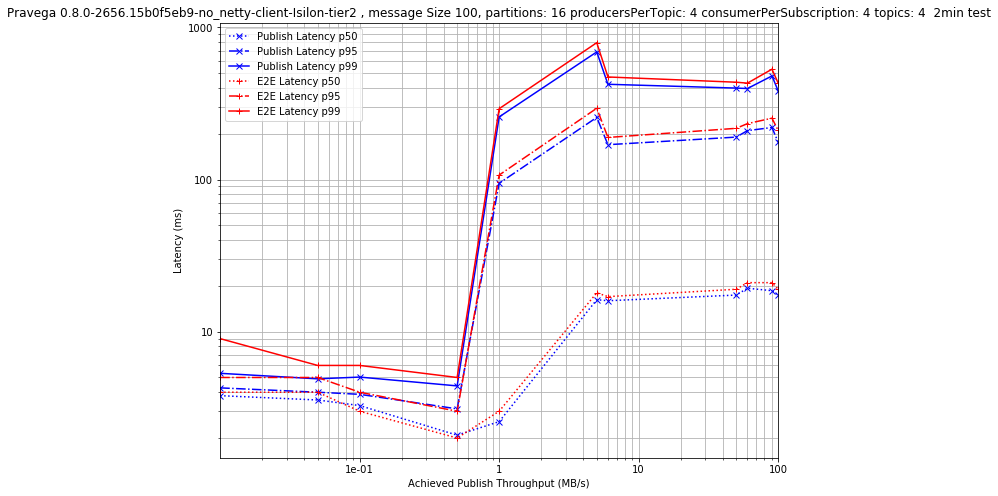

In [1950]:
plot_latency_vs_publish_throughput(filt_100_df)

In [1951]:
latency_vs_publish_throughput_table(filt_100_df)

,Publish Latency p50,Publish Latency p95,Publish Latency p99,E2E Latency p50,E2E Latency p95,E2E Latency p99,test_uuid
Achieved Publish Throughput (MB/s),,,,,,,
0.010015,3.797,4.272,5.325,4.0,5.000,9.000,c202bfac-00dc-4caa-b769-59ca8d86d45a
0.050083,3.557,4.001,4.899,4.0,5.000,6.000,7c4e6a3f-c0ce-4dbe-8c22-5b97bef0d3b1
0.100174,3.268,3.875,5.031,3.0,4.000,6.000,3ae6f705-f582-4662-842d-552bae82daf2
0.500689,2.089,3.110,4.402,2.0,3.000,5.000,ffa737b9-c7d4-4b98-b852-49ac9390806f
1.001685,2.563,94.469,257.903,3.0,107.000,292.001,43d23720-4b21-4cbe-b246-86985892a3aa
5.017857,16.221,255.930,689.479,18.0,294.001,793.003,ffd6ca94-17ef-456a-a0bf-7c215606fb5e
6.035034,15.972,169.392,422.597,17.0,189.000,472.001,77eab127-c0cd-4a09-88f8-cfbb3da106ea
50.140098,17.401,190.029,399.007,19.0,217.000,436.001,f306de9a-9931-4887-9549-e4d1d18323b3
60.389950,19.297,209.575,396.295,21.0,233.000,430.001,63cf6351-3545-4275-8565-fa083e343f06


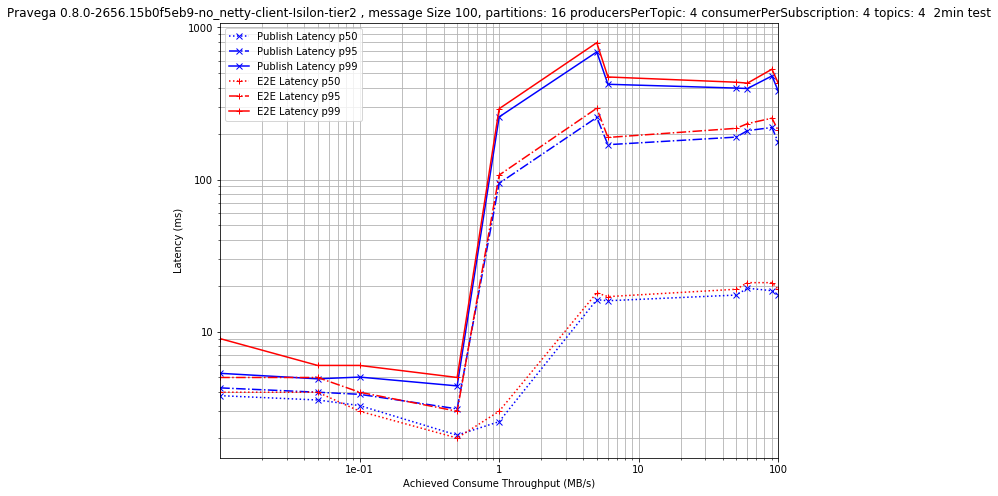

In [1952]:
plot_latency_vs_consume_throughput(filt_100_df)

In [1953]:
latency_vs_consume_throughput_table(filt_100_df)

,Publish Latency p50,Publish Latency p95,Publish Latency p99,E2E Latency p50,E2E Latency p95,E2E Latency p99,test_uuid
Achieved Consume Throughput (MB/s),,,,,,,
0.010014,3.797,4.272,5.325,4.0,5.000,9.000,c202bfac-00dc-4caa-b769-59ca8d86d45a
0.050052,3.557,4.001,4.899,4.0,5.000,6.000,7c4e6a3f-c0ce-4dbe-8c22-5b97bef0d3b1
0.100170,3.268,3.875,5.031,3.0,4.000,6.000,3ae6f705-f582-4662-842d-552bae82daf2
0.500709,2.089,3.110,4.402,2.0,3.000,5.000,ffa737b9-c7d4-4b98-b852-49ac9390806f
1.001750,2.563,94.469,257.903,3.0,107.000,292.001,43d23720-4b21-4cbe-b246-86985892a3aa
5.018681,16.221,255.930,689.479,18.0,294.001,793.003,ffd6ca94-17ef-456a-a0bf-7c215606fb5e
6.034468,15.972,169.392,422.597,17.0,189.000,472.001,77eab127-c0cd-4a09-88f8-cfbb3da106ea
50.139025,17.401,190.029,399.007,19.0,217.000,436.001,f306de9a-9931-4887-9549-e4d1d18323b3
60.390060,19.297,209.575,396.295,21.0,233.000,430.001,63cf6351-3545-4275-8565-fa083e343f06


## Message Size 10 KB

In [1965]:
filt_10000_df = filter_dataframe(
    filt_df,
    messageSize=10000,
    producersPerTopic=4,
    partitionsPerTopic=1,
    numWorkloadWorkers=4,
    version='2.6.0-not-tiered'
    #version='2.5.2',
    #version='0.8.0-2656.15b0f5eb9-no_netty-client-Isilon-tier2'
)

In [1966]:
# View distinct sets of parameters.
# There should only be one distinct set of parameters.
filt_10000_df[param_cols].drop_duplicates().T

test_uuid,fdbfae2d-c81c-4359-8682-7dbf89ba987d
numWorkloadWorkers,4
topics,4
partitionsPerTopic,1
producersPerTopic,4
subscriptionsPerTopic,1
consumerPerSubscription,4
testDurationMinutes,2
keyDistributor,NO_KEY
git_commit,712d559
driverName,Pulsar


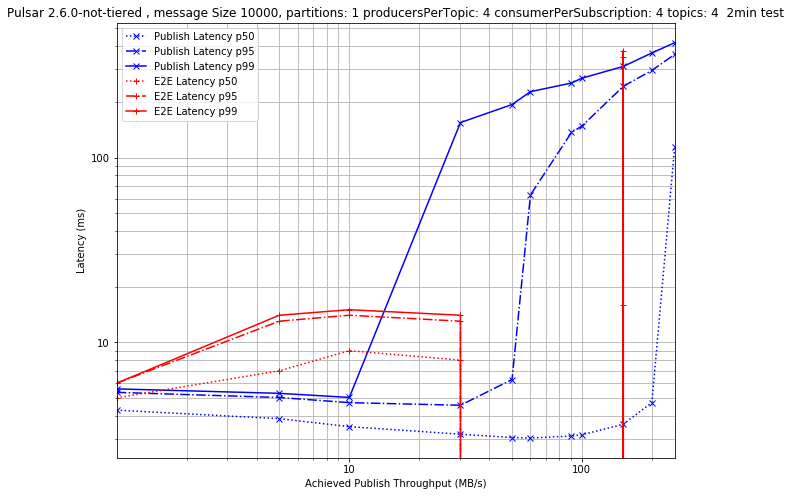

In [1967]:
plot_latency_vs_publish_throughput(filt_10000_df)

In [1968]:
latency_vs_publish_throughput_table(filt_10000_df)

,Publish Latency p50,Publish Latency p95,Publish Latency p99,E2E Latency p50,E2E Latency p95,E2E Latency p99,test_uuid
Achieved Publish Throughput (MB/s),,,,,,,
1.001794,4.286,5.352,5.589,5.0,6.000,6.000,fdbfae2d-c81c-4359-8682-7dbf89ba987d
5.008542,3.855,5.019,5.287,7.0,13.000,14.000,3055e9ca-1ce8-48c7-89dd-88ef594f5eb6
10.018978,3.490,4.708,5.023,9.0,14.000,15.000,4972b49f-8687-4ffa-9a62-4a99f1e995c2
30.092712,3.176,4.556,154.712,8.0,13.000,14.000,b150790b-4941-4de1-8f5a-61e6a9071290
50.140931,3.047,6.280,193.736,0.0,0.000,0.000,f436b00b-0be5-44be-8cae-22fa0544a14b
60.185440,3.028,62.817,227.431,0.0,0.000,0.000,e6ebfba0-e4a4-40f9-98c1-f0f86abe0383
90.329937,3.107,136.767,253.345,0.0,0.000,0.000,57562dd6-a082-47b1-b9e2-6497adbbada8
100.259056,3.153,148.220,269.289,0.0,0.000,0.000,701a932c-6bd4-48c7-98cc-52ee6dbf65a2
150.772580,3.596,243.076,311.431,16.0,349.001,379.001,a409aada-b08a-41b8-8307-cde8e2b37a97


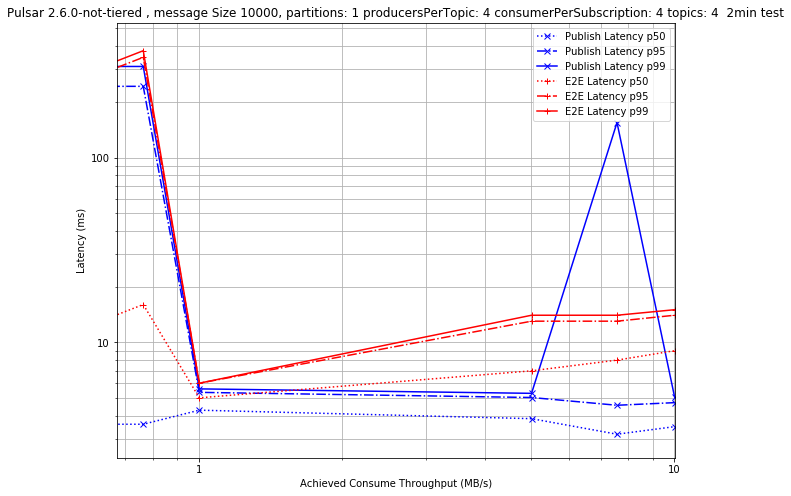

In [1969]:
plot_latency_vs_consume_throughput(filt_10000_df)

In [1970]:
latency_vs_consume_throughput_table(filt_10000_df)

,Publish Latency p50,Publish Latency p95,Publish Latency p99,E2E Latency p50,E2E Latency p95,E2E Latency p99,test_uuid
Achieved Consume Throughput (MB/s),,,,,,,
0.000000,3.153,148.220,269.289,0.0,0.000,0.000,701a932c-6bd4-48c7-98cc-52ee6dbf65a2
0.000000,3.028,62.817,227.431,0.0,0.000,0.000,e6ebfba0-e4a4-40f9-98c1-f0f86abe0383
0.000000,3.047,6.280,193.736,0.0,0.000,0.000,f436b00b-0be5-44be-8cae-22fa0544a14b
0.000000,3.107,136.767,253.345,0.0,0.000,0.000,57562dd6-a082-47b1-b9e2-6497adbbada8
0.000000,114.685,361.923,418.895,0.0,0.000,0.000,9d0cfee6-fdf9-43b8-9fb5-15344628f1e9
0.000000,4.712,296.347,368.579,0.0,0.000,0.000,73097645-007e-472c-9b65-dece6ae15a27
0.763701,3.596,243.076,311.431,16.0,349.001,379.001,a409aada-b08a-41b8-8307-cde8e2b37a97
1.001794,4.286,5.352,5.589,5.0,6.000,6.000,fdbfae2d-c81c-4359-8682-7dbf89ba987d
5.008706,3.855,5.019,5.287,7.0,13.000,14.000,3055e9ca-1ce8-48c7-89dd-88ef594f5eb6


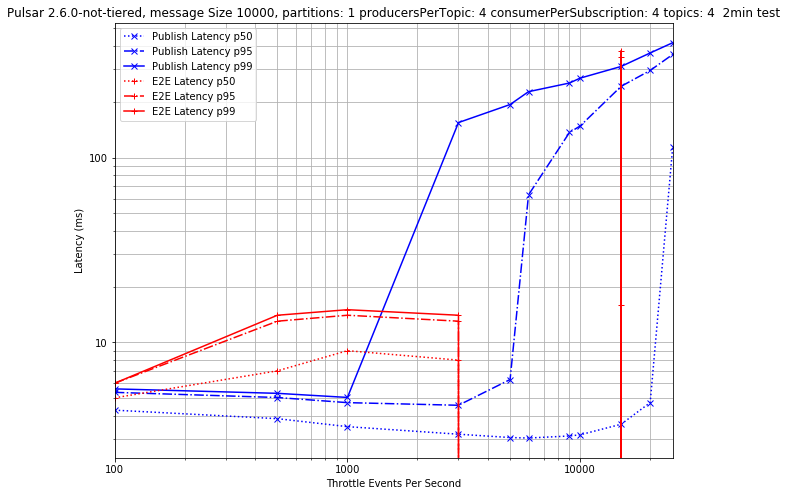

In [1971]:
plot_latency_vs_provided_rate(filt_10000_df)

In [1972]:
latency_vs_provided_rate_table(filt_10000_df)

,Publish Latency p50,Publish Latency p95,Publish Latency p99,E2E Latency p50,E2E Latency p95,E2E Latency p99,test_uuid
Throttle Events Per Second,,,,,,,
100.0,4.286,5.352,5.589,5.0,6.000,6.000,fdbfae2d-c81c-4359-8682-7dbf89ba987d
500.0,3.855,5.019,5.287,7.0,13.000,14.000,3055e9ca-1ce8-48c7-89dd-88ef594f5eb6
1000.0,3.490,4.708,5.023,9.0,14.000,15.000,4972b49f-8687-4ffa-9a62-4a99f1e995c2
3000.0,3.176,4.556,154.712,8.0,13.000,14.000,b150790b-4941-4de1-8f5a-61e6a9071290
5000.0,3.047,6.280,193.736,0.0,0.000,0.000,f436b00b-0be5-44be-8cae-22fa0544a14b
6000.0,3.028,62.817,227.431,0.0,0.000,0.000,e6ebfba0-e4a4-40f9-98c1-f0f86abe0383
9000.0,3.107,136.767,253.345,0.0,0.000,0.000,57562dd6-a082-47b1-b9e2-6497adbbada8
10000.0,3.153,148.220,269.289,0.0,0.000,0.000,701a932c-6bd4-48c7-98cc-52ee6dbf65a2
15000.0,3.596,243.076,311.431,16.0,349.001,379.001,a409aada-b08a-41b8-8307-cde8e2b37a97


## Analyze 100 B events, 50,000 events/sec, various number of partitions and producers

In [1963]:
filt_50000eps_df = filter_dataframe(
    filt_df,
    messageSize=100,
    producerRate=-1,
).sort_values(['endToEndLatencyMs99Pct'], ascending=True)
len(filt_50000eps_df)

filter_dataframe: No matching records after filtering on producerRate=[-1]


0

In [1964]:
take_varying_columns(filt_50000eps_df[cols]).head(20)

""
test_uuid


# Analyze Latency Distribution

In [1775]:
test_uuid = filt_50000eps_df.iloc[0].name
test_uuid

IndexError: single positional indexer is out-of-bounds

In [1683]:
df = clean_df
t = df[df.test_uuid==test_uuid].iloc[0]

IndexError: single positional indexer is out-of-bounds

In [1684]:
# Cumulative Distribution Function
pubcdf = t.aggregatedPublishLatencyQuantiles
pubcdf.name = 'Publish Latency CDF'

In [1685]:
# Probability Distribution Function (latency histogram)
pubpdf = pd.Series(index=pubcdf.index, data=np.gradient(pubcdf, pubcdf.index.values), name='Publish Latency PDF')

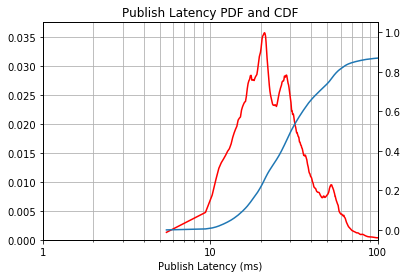

In [1686]:
fig0, ax0 = plt.subplots()
ax1 = ax0.twinx()
pubpdf.plot(ax=ax0, xlim=[1,100], ylim=[0,None], style='r', title='Publish Latency PDF and CDF')
pubcdf.plot(ax=ax1, xlim=[1,100], secondary_y=True, logx=True, ylim=[0,1])
# ax0.set_ylabel('PDF');
# ax1.set_ylabel('CDF');
ax0.set_xlabel('Publish Latency (ms)');
tick_formatter = matplotlib.ticker.LogFormatter()
ax0.xaxis.set_major_formatter(tick_formatter)
ax0.grid('on', which='both', axis='both')
plt.show()
plt.close()

In [1687]:
# Cumulative Distribution Function
e2ecdf = t.aggregatedEndToEndLatencyQuantiles
e2ecdf.name = 'E2E Latency CDF'
# Probability Distribution Function (latency histogram)
e2epdf = pd.Series(index=e2ecdf.index, data=np.gradient(e2ecdf, e2ecdf.index.values), name='E2E Latency PDF')

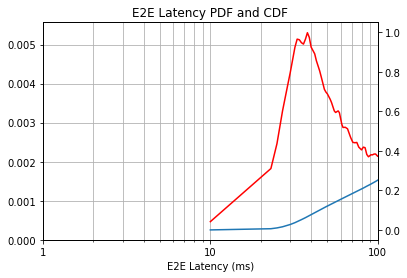

In [1688]:
fig0, ax0 = plt.subplots()
ax1 = ax0.twinx()
e2epdf.plot(ax=ax0, xlim=[1,100], ylim=[0,None], style='r', title='E2E Latency PDF and CDF')
e2ecdf.plot(ax=ax1, xlim=[1,100], secondary_y=True, logx=True, ylim=[0,1])
# ax0.set_ylabel('PDF');
# ax1.set_ylabel('CDF');
ax0.set_xlabel('E2E Latency (ms)');
tick_formatter = matplotlib.ticker.LogFormatter()
ax0.xaxis.set_major_formatter(tick_formatter)
ax0.grid('on', which='both', axis='both')
plt.show()
plt.close()

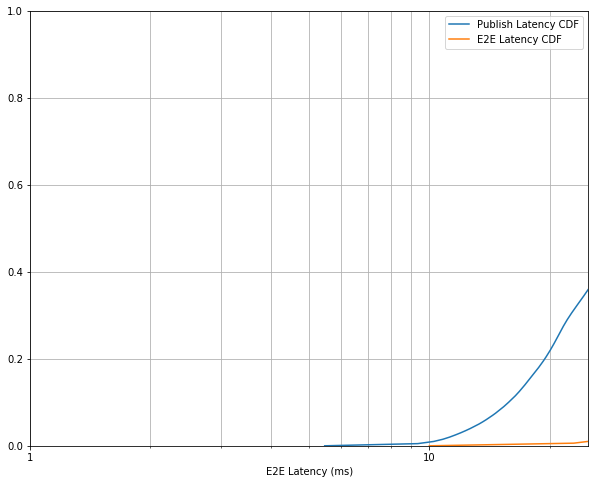

In [1689]:
# Combined publish and E2E latency CDF
fig0, ax0 = plt.subplots()
xlim=[1,25]
pubcdf.plot(ax=ax0, xlim=xlim, logx=True, ylim=[0,1], legend=True, figsize=(10,8))
e2ecdf.plot(ax=ax0, xlim=xlim, logx=True, ylim=[0,1], legend=True)
ax0.set_xlabel('E2E Latency (ms)');
tick_formatter = matplotlib.ticker.LogFormatter()
ax0.xaxis.set_major_formatter(tick_formatter)
ax0.grid('on', which='both', axis='both')
plt.show()
plt.close()

## Compare Two Sets

In [1693]:
# Common filter
filt_df = filter_dataframe(
    clean_df,
    numWorkloadWorkers=4, 
    topics=4,
    testDurationMinutes=2,
    #size_of_test_batch=(2,1000), # between
    #aggregatedEndToEndLatency50pct=(1,1e6),
    messageSize=10000,
    producersPerTopic=4,
    partitionsPerTopic=16,    
)
len(filt_df)

25

In [1694]:
# Set 1
filt1_df = filter_dataframe(
    filt_df,
    version='2.6.0-not-tiered',
    #pravegaVersion='0.8.0-2656.15b0f5eb9-no_netty-client-Isilon-tier2' 
    #pravegaVersion='0.8.0-2656.1c40f1e-Isilon-tier2',
)
len(filt1_df)

12

In [1695]:
# Set 2
filt2_df = filter_dataframe(
    filt_df,
    #version='2.6.0-ecs-s3-tier2'
    version='2.5.2',
    #pravegaVersion='0.8.0-2656.1c40f1e-Isilon-tier2',
)
len(filt2_df)

13

In [1696]:
dfs = [filt1_df, filt2_df]
take_varying_columns(pd.concat(dfs)[param_cols]).drop_duplicates()

,git_commit,version
test_uuid,,
8ab39902-5742-41e1-a00b-ce423466273c,712d559,2.6.0-not-tiered
ca6c67ac-af4f-4cf7-aa22-223f7cf775af,1793eb2,2.5.2


In [1697]:
def plot_latency_vs_throughput_comparison(dfs, legend_cols=None, latencyMetric='Publish'):
    fig0, ax0 = plt.subplots()
    cmap = plt.get_cmap('Set1')
    colors = cmap.colors[0:len(dfs)]
    pravegaVersion = filt1_df.version.iloc[0]
    pravegaDriver = filt1_df.driver.iloc[0]
    pulsarVersion = filt2_df.version.iloc[0]
    pulsaraDriver = filt2_df.driver.iloc[0]
    messageSize = filt2_df.messageSize.iloc[0]
    msgSize = '%db' % (messageSize)
    if messageSize >= 1000:
        msgSize = '%dk' % (messageSize/1000)
    
    partitionsPerTopic = filt2_df.partitionsPerTopic.iloc[0]
    testDurationMinutes = filt2_df.testDurationMinutes.iloc[0]
    topics = filt2_df.topics.iloc[0]
    producersPerTopic = filt2_df.producersPerTopic.iloc[0]
    consumerPerSubscription = filt2_df.consumerPerSubscription.iloc[0]
    
    title = 'Compare %s %s and %s %s [messageSize %s, partitions: %d producersPerTopic: %d consumerPerSubscription: %d topics: %d] on %d min test' % (pravegaDriver, pravegaVersion, pulsaraDriver, pulsarVersion, msgSize, partitionsPerTopic, producersPerTopic, consumerPerSubscription, topics, testDurationMinutes)
   
    for index, (df, color) in enumerate(zip(dfs, colors)):
        df = df.set_index(['publishRateMBPerSecMean']).sort_index()
        name_cols = df.iloc[0][legend_cols]
        name = ','.join(['%s=%s' % item for item in name_cols.to_dict().items()])
    
        plot_df = latency_vs_provided_rate_table(df)
        
        for percentile, style in [('50',':x'), ('95','-.x'), ('99','-x')]:
            plot_df = df[['aggregated%sLatency%spct' % (latencyMetric, percentile)]]
            plot_df.columns = ['%s %s Latency p%s' % (name, latencyMetric, percentile)]
            plot_df.index.name = 'Achieved Publish Throughput (MB/s)'
            plot_df.plot(
                ax=ax0,
                logx=True, 
                logy=True,
                figsize=(10,8),
                grid=True,
                style=style,
                color=color,
                title=title 
            )
    ax0.set_ylabel('Latency (ms)');
    tick_formatter = matplotlib.ticker.LogFormatter()
    ax0.xaxis.set_major_formatter(tick_formatter)
    ax0.yaxis.set_major_formatter(tick_formatter)
    ax0.grid('on', which='both', axis='both')

In [1698]:
def plot_latency_vs_provided_rate_comparison(dfs, legend_cols=None, latencyMetric='Publish'):
    fig0, ax0 = plt.subplots()
    cmap = plt.get_cmap('Set1')
    colors = cmap.colors[0:len(dfs)]
    pravegaVersion = filt1_df.version.iloc[0]
    pravegaDriver = filt1_df.driver.iloc[0]
    pulsarVersion = filt2_df.version.iloc[0]
    pulsaraDriver = filt2_df.driver.iloc[0]
    messageSize = filt2_df.messageSize.iloc[0]
    msgSize = '%db' % (messageSize)
    if messageSize >= 1000:
        msgSize = '%dk' % (messageSize/1000)
    
    partitionsPerTopic = filt2_df.partitionsPerTopic.iloc[0]
    testDurationMinutes = filt2_df.testDurationMinutes.iloc[0]
    topics = filt2_df.topics.iloc[0]
    producersPerTopic = filt2_df.producersPerTopic.iloc[0]
    consumerPerSubscription = filt2_df.consumerPerSubscription.iloc[0]
    
    title = 'Compare %s %s and %s %s [messageSize %s, partitions: %d producersPerTopic: %d consumerPerSubscription: %d topics: %d] on %d min test' % (pravegaDriver, pravegaVersion, pulsaraDriver, pulsarVersion, msgSize, partitionsPerTopic, producersPerTopic, consumerPerSubscription, topics, testDurationMinutes)
    
    for index, (df, color) in enumerate(zip(dfs, colors)):
        df = df.set_index(['throttleEventsPerSec']).sort_index()
        name_cols = df.iloc[0][legend_cols]
        name = ','.join(['%s=%s' % item for item in name_cols.to_dict().items()])
               
        for percentile, style in [('50',':x'), ('95','-.x'), ('99','-x')]:
            plot_df = df[['aggregated%sLatency%spct' % (latencyMetric, percentile)]]
            plot_df.columns = ['%s %s Latency p%s' % (name, latencyMetric, percentile)]
            plot_df.index.name = 'Provided Rate (Events/s)'
            plot_df.plot(
                ax=ax0,
                logx=True, 
                logy=True,
                figsize=(10,8),
                grid=True,
                style=style,
                color=color,
                title=title 
            )
    ax0.set_ylabel('Latency (ms)');
    tick_formatter = matplotlib.ticker.LogFormatter()
    ax0.xaxis.set_major_formatter(tick_formatter)
    ax0.yaxis.set_major_formatter(tick_formatter)
    ax0.grid('on', which='both', axis='both')

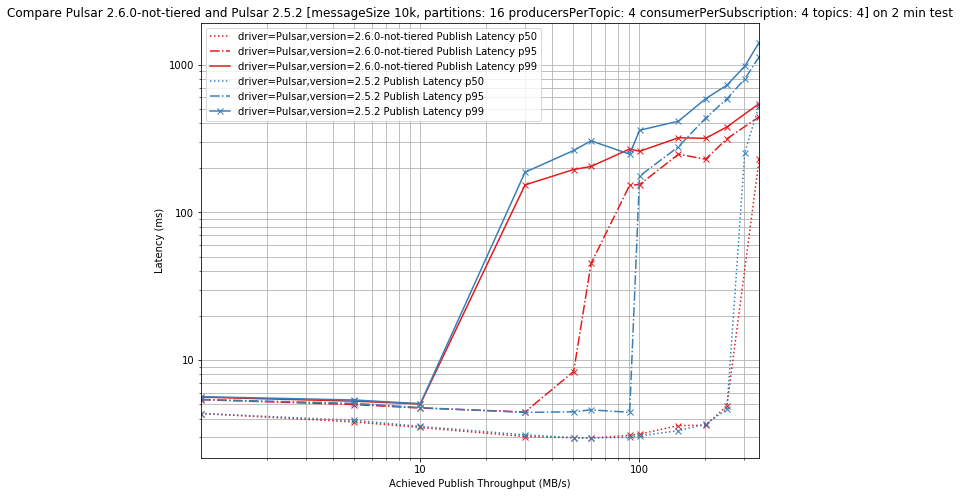

In [1699]:
plot_latency_vs_throughput_comparison([filt1_df, filt2_df], legend_cols=['driver', 'version'], latencyMetric='Publish')

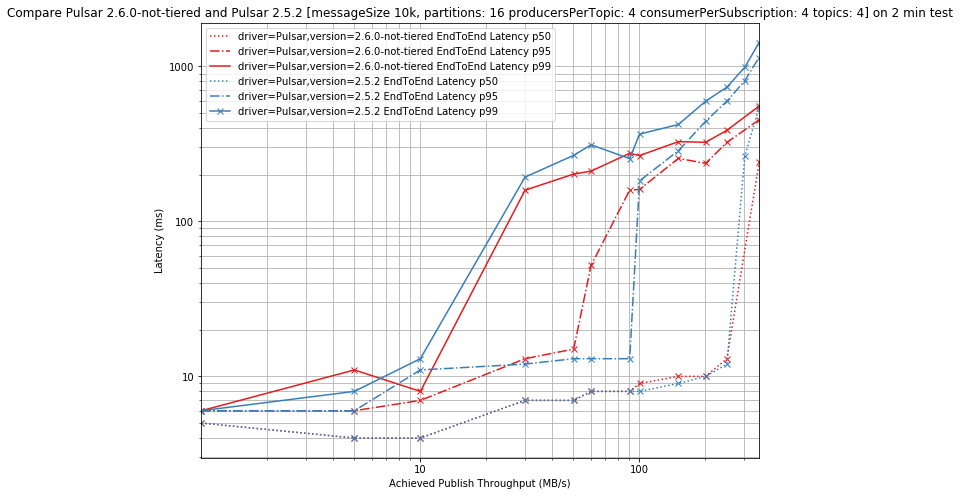

In [1700]:
plot_latency_vs_throughput_comparison([filt1_df, filt2_df], legend_cols=['driver', 'version'], latencyMetric='EndToEnd')

In [1701]:
### Latency vs Provided Rate 

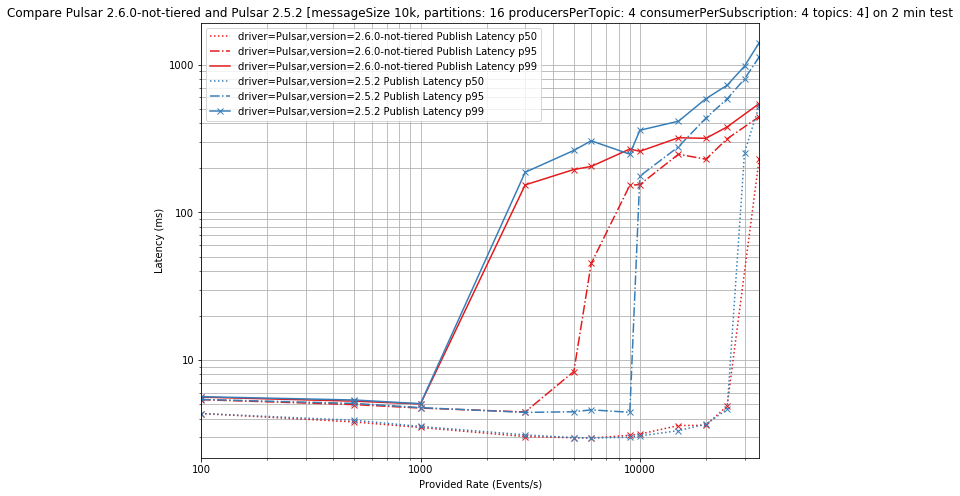

In [1702]:
plot_latency_vs_provided_rate_comparison([filt1_df, filt2_df], legend_cols=['driver', 'version'], latencyMetric='Publish')

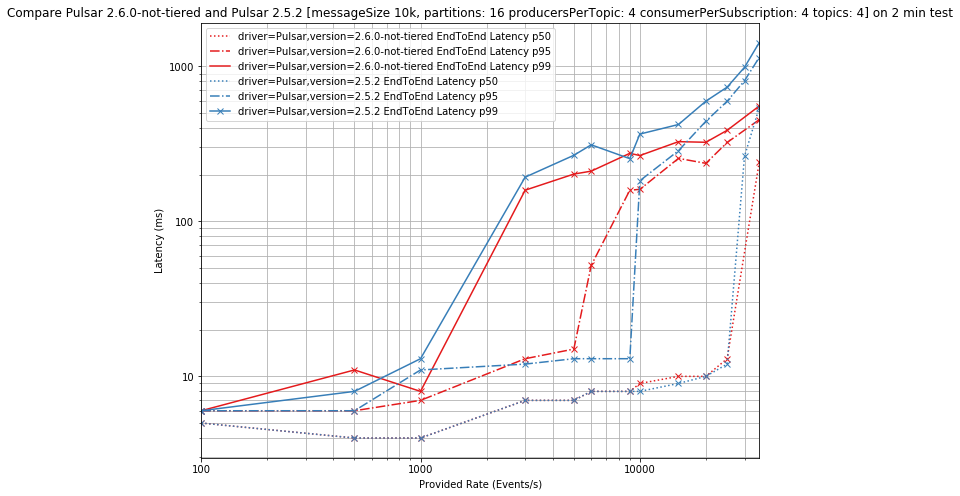

In [1703]:
plot_latency_vs_provided_rate_comparison([filt1_df, filt2_df], legend_cols=['driver', 'version'], latencyMetric='EndToEnd')